In [17]:
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split

import matplotlib.pyplot as plt
%matplotlib inline

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Implement a PyTorch model with Adam on FashionMnist

There are many optimizers that employ adaptive learning rates to account for the different learning rate needs at different phases of training. Your job is to first implement such an optimizer and see its performance. For now, we are using

### a. Download Data FashionMnist

In [3]:
%%capture
transform_method = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_method)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_method)

In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""
for test_images, test_labels in train_loader:  
    sample_image = test_images[0]
    sample_label = test_labels[0]
    plt.imshow(sample_image[0], cmap='gray')
"""
""

''

### b. Implement a Logistic Regression Model and Fit the Data with Adam

In [32]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        if not (epoch+1) % 5 == 0:
            return
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))
        
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3072, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 64)
        self.linear4 = nn.Linear(64, 64)
        self.linear5 = nn.Linear(64, 10)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

def accuracy(outputs, labels):
    max_probabilities, predictions = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
model1 = CIFAR10Model().to(device)
history1 = fit(40, 0.0005, model1, train_loader, test_loader, torch.optim.Adam)

Epoch [0], val_loss: 1.8303, val_acc: 0.3405
Epoch [1], val_loss: 1.6696, val_acc: 0.4050
Epoch [2], val_loss: 1.6083, val_acc: 0.4202
Epoch [3], val_loss: 1.5398, val_acc: 0.4508
Epoch [4], val_loss: 1.4990, val_acc: 0.4699
Epoch [5], val_loss: 1.4981, val_acc: 0.4617
Epoch [6], val_loss: 1.4498, val_acc: 0.4857
Epoch [7], val_loss: 1.4257, val_acc: 0.4977
Epoch [8], val_loss: 1.4083, val_acc: 0.4997
Epoch [9], val_loss: 1.3863, val_acc: 0.5096
Epoch [10], val_loss: 1.3884, val_acc: 0.5105
Epoch [11], val_loss: 1.3758, val_acc: 0.5158
Epoch [12], val_loss: 1.3681, val_acc: 0.5208
Epoch [13], val_loss: 1.3634, val_acc: 0.5189
Epoch [14], val_loss: 1.3574, val_acc: 0.5180
Epoch [15], val_loss: 1.3422, val_acc: 0.5296
Epoch [16], val_loss: 1.3403, val_acc: 0.5264
Epoch [17], val_loss: 1.3291, val_acc: 0.5320
Epoch [18], val_loss: 1.3661, val_acc: 0.5223
Epoch [19], val_loss: 1.3597, val_acc: 0.5292
Epoch [20], val_loss: 1.3362, val_acc: 0.5367
Epoch [21], val_loss: 1.3299, val_acc: 0.545

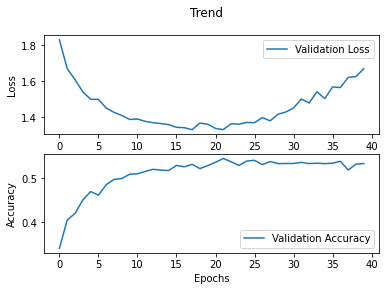

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle("Trend")
val_loss = [element["val_loss"] for element in history1]
val_accuracy = [element["val_acc"] for element in history1]
ax1.plot(val_loss, label="Validation Loss")
ax2.plot(val_accuracy, label="Validation Accuracy")
ax1.legend()
ax1.set_ylabel("Loss")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

## 2. Implement Adam with HD, and comprare it with Vanilla Adam

## 3. Compare MARTHE on Adam to AdamHD
Implement MARTHE. Use the learning rate scheduling to tune the learning rate of Adam, and compare the results to Adam with HD.

In [6]:
"""
import sys  
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    # Change the line below to include the directory you are currently in
    sys.path.append(module_path+"\\project\\problem set")
print(sys.path)"""

from adatune.data_loader import *
from adatune.mu_adam import MuAdam
from adatune.mu_sgd import MuSGD
from adatune.network import *
from adatune.utils import *

In [7]:
def train_rtho(network_name, dataset, num_epoch, batch_size, optim_name, lr, momentum, wd, hyper_lr, alpha,
               grad_clipping, first_order, seed, mu=1.0):
    torch.manual_seed(seed)

    # We are using cuda for training - no point trying out on CPU for ResNet
    device = torch.device("cuda")

    net = network(network_name, dataset)
    net.to(device).apply(init_weights)

    # assign argparse parameters
    criterion = nn.CrossEntropyLoss().to(device)
    best_val_accuracy = 0.0
    cur_lr = lr
    timestep = 0

    train_data, test_data = data_loader(network, dataset, batch_size)

    if optim_name == 'adam':
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd, eps=1e-4)
        hyper_optim = MuAdam(optimizer, hyper_lr, grad_clipping, first_order, mu, alpha, device)
    else:
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=wd)
        hyper_optim = MuSGD(optimizer, hyper_lr, grad_clipping, first_order, mu, alpha, device)

    vg = ValidationGradient(test_data, nn.CrossEntropyLoss(), device)
    for epoch in range(num_epoch):
        train_correct = 0
        train_loss = 0

        for inputs, labels in train_data:
            net.train()
            timestep += 1

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            train_pred = outputs.argmax(1)
            train_correct += train_pred.eq(labels).sum().item()

            first_grad = ag.grad(loss, net.parameters(), create_graph=True, retain_graph=True)

            hyper_optim.compute_hg(net, first_grad)

            for params, gradients in zip(net.parameters(), first_grad):
                params.grad = gradients

            optimizer.step()
            hyper_optim.hyper_step(vg.val_grad(net))
            clear_grad(net)

        train_acc = 100.0 * (train_correct / len(train_data.dataset))
        val_loss, val_acc = compute_loss_accuracy(net, test_data, criterion, device)

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc

        print('train_accuracy at epoch :{} is : {}'.format(epoch, train_acc))
        print('val_accuracy at epoch :{} is : {}'.format(epoch, val_acc))
        print('best val_accuracy is : {}'.format(best_val_accuracy))

        cur_lr = 0.0
        for param_group in optimizer.param_groups:
            cur_lr = param_group['lr']
        print('learning_rate after epoch :{} is : {}'.format(epoch, cur_lr))

In [8]:
#train_with_marthe(model3, 0.001, train_loader, test_loader, 10)
train_rtho("resnet", "cifar_10", 10, 16, "adam", 0.0001, 0.9, 0, 0.0001, 1e-6, 100.0, False, 42)

Files already downloaded and verified


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 914.10 MiB already allocated; 0 bytes free; 958.00 MiB reserved in total by PyTorch)

## 4. Task for Graduate Students
### a. Repeat task 1 and task 2 on VGG. Compare performance increase of AdamHD on the non-convex optimization problem when compared to Adam.
Comment on your findings and explain.